In [ ]:
# Core Python libraries
import os
from collections import Counter
import copy
import json
import sys

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import PIL
# import cv2

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR,CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.models as m
from torchvision import datasets, models, transforms

# Model summary and info
import torchinfo
from torchinfo import summary

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

# Progress bar for training loops
from tqdm import tqdm

In [2]:
# Print library versions for reproducibility
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

# Check Python version
!python --version

torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
torchinfo version :  1.8.0
numpy version :  1.26.4
matplotlib version :  3.7.2
Python 3.11.11


In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [4]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
# ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [6]:
train_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


test_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [7]:
classes = ['Normal','Pneumonia','TB']

In [8]:
torch.manual_seed(42)

full_train_data = datasets.ImageFolder(
    '/kaggle/input/pneumonia-tb-dataset/Combined_Dataset_12856/Combined_Dataset_12856/Train',
    transform=train_transforms
)

# Split into training and validation
train_size =  int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])


test_data = datasets.ImageFolder('/kaggle/input/pneumonia-tb-dataset/Combined_Dataset_12856/Combined_Dataset_12856/Test', transform=test_transforms)

print("Length of training dataset:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data),'\n')

Length of training dataset: 10401
Validation set size: 1156
Test set size: 1284 



In [9]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

100%|██████████| 10401/10401 [02:47<00:00, 62.16it/s]


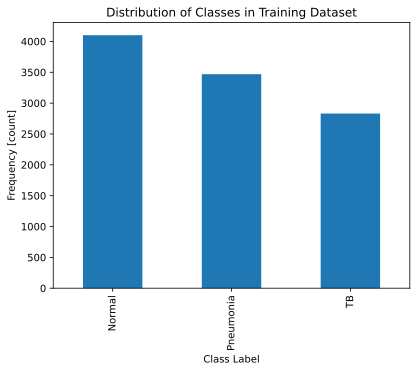

In [10]:
train_counts = class_counts(train_data)

# Bar chart from the function output
train_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

100%|██████████| 1156/1156 [00:19<00:00, 60.50it/s]


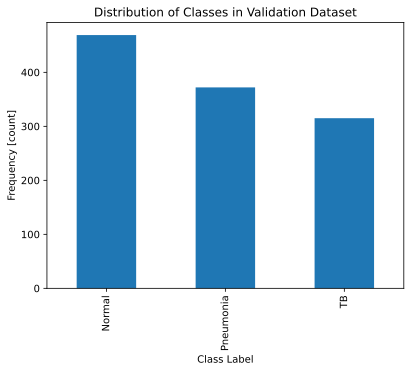

In [11]:
val_counts = class_counts(val_data)

# Bar chart from the function output
val_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

100%|██████████| 1284/1284 [00:11<00:00, 109.85it/s]


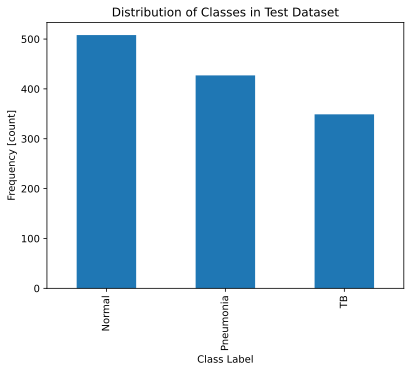

In [12]:
test_counts = class_counts(test_data)

# Bar chart from the function output
test_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Test Dataset");

In [13]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True, drop_last=False)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)

In [21]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    lossfun,
    epochs=10,
    device='cpu',
    save_path='/kaggle/working/best_model.pth',
    patience=3,
    scheduler=None,
):
    model.to(device)
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) 
    early_stop_counter = 0 
    
    # Initialize lists
    trainAcc = []
    trainLoss = [] 
    valAcc = []
    valLoss = []
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Training phase
        train_batchAcc = []
        train_batchLoss = []
        model.train()
        
        for X, y in tqdm(train_loader, desc='Training', leave=True):
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = lossfun(yHat, y)  
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            train_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
            train_batchLoss.append(loss.item())
        
        # Store epoch metrics
        trainAcc.append(np.mean(train_batchAcc))
        trainLoss.append(np.mean(train_batchLoss)) 
        
        print(f"Training Loss: {trainLoss[epoch - 1]:.4f} | Training Accuracy: {trainAcc[-1]:.2f}%")
        
        # Validation phase
        model.eval()
        val_batchAcc = []
        val_batchLoss = []
        
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc='Validating', leave=True):
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = lossfun(yHat, y)
                
                val_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
                val_batchLoss.append(loss.item())
        
        # Store epoch metrics
        valAcc.append(np.mean(val_batchAcc))
        valLoss.append(np.mean(val_batchLoss))
        
        print(f"Validation Loss: {valLoss[epoch - 1]:.4f} | Validation Accuracy: {valAcc[-1]:.2f}%")
        
        # Learning rate scheduling
        if scheduler:
            if hasattr(scheduler, 'step'):
                # For ReduceLROnPlateau
                if 'ReduceLROnPlateau' in str(type(scheduler)):
                    scheduler.step(valLoss[epoch - 1]) 
                else:
                    # For other schedulers like StepLR
                    scheduler.step()
        
        # Early stopping and model saving
        if valAcc[-1] > best_val_acc:
            best_val_acc = valAcc[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print(f"✅ New best validation accuracy: {best_val_acc:.2f}%")
        else:
            early_stop_counter += 1
            print(f"⏳ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        
        if early_stop_counter > patience:
            print("🛑 Early stopping triggered.")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\n🏆 Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    
    return model, trainAcc, trainLoss, valAcc, valLoss

In [22]:
def get_custom_classifier(in_features, num_classes=3):
    return nn.Sequential(
        nn.Linear(in_features, 512),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(32, num_classes)
    )

In [23]:
BASE_DIR = "/kaggle/working/model_results"
os.makedirs(BASE_DIR, exist_ok=True)

In [24]:
def train_model_by_name(model_name, train_loader, val_loader, num_classes, device='cuda', epochs=10, patience=3):
    model_name = model_name.lower()
    model_dir = os.path.join(BASE_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)

    if model_name == 'densenet121':
        weights = m.DenseNet121_Weights.DEFAULT
        model = m.densenet121(weights=weights)
        in_features = model.classifier.in_features
        model.classifier = get_custom_classifier(in_features, num_classes)

    elif model_name == 'resnet50':
        weights = m.ResNet50_Weights.DEFAULT
        model = m.resnet50(weights=weights)
        in_features = model.fc.in_features
        model.fc = get_custom_classifier(in_features, num_classes)

    elif model_name == 'resnet101':
        weights = m.ResNet101_Weights.DEFAULT
        model = m.resnet101(weights=weights)
        in_features = model.fc.in_features
        model.fc = get_custom_classifier(in_features, num_classes)

    elif model_name == 'efficientnet_b0':
        weights = m.EfficientNet_B0_Weights.DEFAULT
        model = m.efficientnet_b0(weights=weights)
        in_features = model.classifier[1].in_features
        model.classifier = get_custom_classifier(in_features, num_classes)

    elif model_name == 'efficientnet_b4':
        weights = m.EfficientNet_B4_Weights.DEFAULT
        model = m.efficientnet_b4(weights=weights)
        in_features = model.classifier[1].in_features
        model.classifier = get_custom_classifier(in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    model = model.to(device)

    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    save_path = os.path.join(model_dir, f"{model_name}_best.pth")
    model, trainAcc, trainLoss, valAcc, valLoss = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        lossfun=lossfun,
        epochs=epochs,
        device=device,
        save_path=save_path,
        patience=patience,
        scheduler=scheduler,
    )
    
    with open(os.path.join(model_dir, f"{model_name}_metrics.json"), "w") as f:
        json.dump({
            "trainAcc": trainAcc,
            "trainLoss": trainLoss,
            "valAcc": valAcc,
            "valLoss": valLoss
        }, f)

    return model, trainAcc, trainLoss, valAcc, valLoss, model_dir

In [25]:
def summarize_model_results(base_dir=BASE_DIR):
    summary = []
    for model_name in os.listdir(base_dir):
        model_dir = os.path.join(base_dir, model_name)
        metrics_file = os.path.join(model_dir, f"{model_name}_metrics.json")
        if os.path.exists(metrics_file):
            with open(metrics_file, "r") as f:
                data = json.load(f)
                max_val_acc = max(data["valAcc"])
                min_val_loss = min(data["valLoss"])
                summary.append({
                    "Model": model_name,
                    "Best Val Accuracy": max_val_acc,
                    "Min Val Loss": min_val_loss
                })

    df = pd.DataFrame(summary)
    df.sort_values(by="Best Val Accuracy", ascending=False, inplace=True)
    df.to_csv(os.path.join(base_dir, "model_summary.csv"), index=False)
    print("\n📊 Model Performance Summary:")
    print(df)
    return df

In [26]:
def evaluate_and_plot_model(model, test_loader, trainAcc, trainLoss, valAcc, valLoss, class_names, device='cuda', model_name='model'):
    
    output_dir = os.path.join(BASE_DIR, model_name)
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
            all_probs.append(probs.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()

    # Plot 1: Accuracy & Loss
    epochs = range(1, len(trainAcc)+1)
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(trainLoss,'o-', label='Train Loss')
    plt.plot(valLoss,'o-', label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(trainAcc,'o-', label='Train Acc')
    plt.plot(valAcc,'o-', label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_dir}/{model_name}_loss_accuracy.png')
    plt.close()

    # Plot 2: Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{output_dir}/{model_name}_confusion_matrix.png')
    plt.close()

    # Print classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'{output_dir}/{model_name}_classification_report.csv')
    print("Classification Report:")
    print(df_report)

    # Binarize labels for ROC & PR curve
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

    # Plot 3: ROC Curve and AUC
    plt.figure()
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(f'{output_dir}/{model_name}_roc_curve.png')
    plt.close()

    # Plot 4: Precision-Recall Curve
    plt.figure()
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        ap_score = average_precision_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.savefig(f'{output_dir}/{model_name}_precision_recall_curve.png')
    plt.close()

In [28]:
model_names = ['densenet121', 'resnet50', 'resnet101', 'efficientnet_b0', 'efficientnet_b4']

In [29]:
name = model_names[0]

print(f"\n🚀 Training model: {name}")

trained_model, trainAcc, trainLoss, valAcc, valLoss, model_dir = train_model_by_name(
    model_name=name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=3,
    device='cuda',
    epochs=10,
    patience=5
)


🚀 Training model: densenet121

Epoch 1/10


Training: 100%|██████████| 325/325 [01:40<00:00,  3.24it/s]


Training Loss: 0.2924 | Training Accuracy: 89.62%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.22it/s]


Validation Loss: 0.0786 | Validation Accuracy: 97.30%
✅ New best validation accuracy: 97.30%

Epoch 2/10


Training: 100%|██████████| 325/325 [01:43<00:00,  3.15it/s]


Training Loss: 0.0991 | Training Accuracy: 96.87%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.16it/s]


Validation Loss: 0.0929 | Validation Accuracy: 96.28%
⏳ No improvement. Early stop counter: 1/5

Epoch 3/10


Training: 100%|██████████| 325/325 [01:44<00:00,  3.10it/s]


Training Loss: 0.0802 | Training Accuracy: 97.30%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.27it/s]


Validation Loss: 0.0718 | Validation Accuracy: 97.47%
✅ New best validation accuracy: 97.47%

Epoch 4/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.07it/s]


Training Loss: 0.0594 | Training Accuracy: 98.06%


Validating: 100%|██████████| 37/37 [00:05<00:00,  7.28it/s]


Validation Loss: 0.0684 | Validation Accuracy: 97.72%
✅ New best validation accuracy: 97.72%

Epoch 5/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.08it/s]


Training Loss: 0.0430 | Training Accuracy: 98.68%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.23it/s]


Validation Loss: 0.0645 | Validation Accuracy: 98.23%
✅ New best validation accuracy: 98.23%

Epoch 6/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.07it/s]


Training Loss: 0.0305 | Training Accuracy: 99.07%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.14it/s]


Validation Loss: 0.0595 | Validation Accuracy: 97.89%
⏳ No improvement. Early stop counter: 1/5

Epoch 7/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.07it/s]


Training Loss: 0.0266 | Training Accuracy: 99.10%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.07it/s]


Validation Loss: 0.0531 | Validation Accuracy: 98.40%
✅ New best validation accuracy: 98.40%

Epoch 8/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.08it/s]


Training Loss: 0.0161 | Training Accuracy: 99.51%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.23it/s]


Validation Loss: 0.0571 | Validation Accuracy: 98.31%
⏳ No improvement. Early stop counter: 1/5

Epoch 9/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.07it/s]


Training Loss: 0.0138 | Training Accuracy: 99.56%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.18it/s]


Validation Loss: 0.0555 | Validation Accuracy: 98.48%
✅ New best validation accuracy: 98.48%

Epoch 10/10


Training: 100%|██████████| 325/325 [01:45<00:00,  3.07it/s]


Training Loss: 0.0095 | Training Accuracy: 99.72%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]


Validation Loss: 0.0488 | Validation Accuracy: 98.56%
✅ New best validation accuracy: 98.56%

🏆 Training completed. Best validation accuracy: 98.56%


In [30]:
evaluate_and_plot_model(
        model=trained_model,
        test_loader=test_loader,
        trainAcc=trainAcc,
        trainLoss=trainLoss,
        valAcc=valAcc,
        valLoss=valLoss,
        class_names=['Normal', 'Pneumonia', 'TB'],
        device='cuda',
        model_name=name
    )

Classification Report:
              precision    recall  f1-score      support
Normal         0.979960  0.962598  0.971202   508.000000
Pneumonia      0.958904  0.983607  0.971098   427.000000
TB             0.997118  0.991404  0.994253   349.000000
accuracy       0.977414  0.977414  0.977414     0.977414
macro avg      0.978661  0.979203  0.978851  1284.000000
weighted avg   0.977621  0.977414  0.977433  1284.000000


In [31]:
name = model_names[1]

print(f"\n🚀 Training model: {name}")

trained_model, trainAcc, trainLoss, valAcc, valLoss, model_dir = train_model_by_name(
    model_name=name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=3,
    device='cuda',
    epochs=10,
    patience=5
)


🚀 Training model: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s] 



Epoch 1/10


Training: 100%|██████████| 325/325 [01:43<00:00,  3.13it/s]


Training Loss: 0.3257 | Training Accuracy: 87.18%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.36it/s]


Validation Loss: 0.1005 | Validation Accuracy: 97.13%
✅ New best validation accuracy: 97.13%

Epoch 2/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.04it/s]


Training Loss: 0.1026 | Training Accuracy: 96.59%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.48it/s]


Validation Loss: 0.0812 | Validation Accuracy: 97.13%
⏳ No improvement. Early stop counter: 1/5

Epoch 3/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.04it/s]


Training Loss: 0.0755 | Training Accuracy: 97.53%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]


Validation Loss: 0.1089 | Validation Accuracy: 96.20%
⏳ No improvement. Early stop counter: 2/5

Epoch 4/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.04it/s]


Training Loss: 0.0583 | Training Accuracy: 98.10%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]


Validation Loss: 0.0663 | Validation Accuracy: 97.72%
✅ New best validation accuracy: 97.72%

Epoch 5/10


Training: 100%|██████████| 325/325 [01:47<00:00,  3.04it/s]


Training Loss: 0.0466 | Training Accuracy: 98.46%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]


Validation Loss: 0.0666 | Validation Accuracy: 97.97%
✅ New best validation accuracy: 97.97%

Epoch 6/10


Training: 100%|██████████| 325/325 [01:47<00:00,  3.04it/s]


Training Loss: 0.0311 | Training Accuracy: 99.03%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.97it/s]


Validation Loss: 0.0908 | Validation Accuracy: 97.30%
⏳ No improvement. Early stop counter: 1/5

Epoch 7/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.04it/s]


Training Loss: 0.0310 | Training Accuracy: 98.96%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]


Validation Loss: 0.0662 | Validation Accuracy: 98.23%
✅ New best validation accuracy: 98.23%

Epoch 8/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.04it/s]


Training Loss: 0.0201 | Training Accuracy: 99.29%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.22it/s]


Validation Loss: 0.0880 | Validation Accuracy: 97.97%
⏳ No improvement. Early stop counter: 1/5

Epoch 9/10


Training: 100%|██████████| 325/325 [01:47<00:00,  3.03it/s]


Training Loss: 0.0163 | Training Accuracy: 99.40%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]


Validation Loss: 0.0563 | Validation Accuracy: 98.23%
⏳ No improvement. Early stop counter: 2/5

Epoch 10/10


Training: 100%|██████████| 325/325 [01:46<00:00,  3.05it/s]


Training Loss: 0.0158 | Training Accuracy: 99.44%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]


Validation Loss: 0.0612 | Validation Accuracy: 98.56%
✅ New best validation accuracy: 98.56%

🏆 Training completed. Best validation accuracy: 98.56%


In [33]:
evaluate_and_plot_model(
        model=trained_model,
        test_loader=test_loader,
        trainAcc=trainAcc,
        trainLoss=trainLoss,
        valAcc=valAcc,
        valLoss=valLoss,
        class_names=['Normal', 'Pneumonia', 'TB'],
        device='cuda',
        model_name=name
    )

Classification Report:
              precision    recall  f1-score      support
Normal         0.987805  0.956693  0.972000   508.000000
Pneumonia      0.954649  0.985948  0.970046   427.000000
TB             0.994302  1.000000  0.997143   349.000000
accuracy       0.978193  0.978193  0.978193     0.978193
macro avg      0.978918  0.980880  0.979730  1284.000000
weighted avg   0.978545  0.978193  0.978184  1284.000000


In [34]:
name = model_names[2]

print(f"\n🚀 Training model: {name}")

trained_model, trainAcc, trainLoss, valAcc, valLoss, model_dir = train_model_by_name(
    model_name=name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=3,
    device='cuda',
    epochs=10,
    patience=5
)


🚀 Training model: resnet101


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 204MB/s]  



Epoch 1/10


Training: 100%|██████████| 325/325 [02:51<00:00,  1.89it/s]


Training Loss: 0.3202 | Training Accuracy: 86.43%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.62it/s]


Validation Loss: 0.1126 | Validation Accuracy: 96.45%
✅ New best validation accuracy: 96.45%

Epoch 2/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.1009 | Training Accuracy: 96.67%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.64it/s]


Validation Loss: 0.0842 | Validation Accuracy: 97.04%
✅ New best validation accuracy: 97.04%

Epoch 3/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.83it/s]


Training Loss: 0.0739 | Training Accuracy: 97.54%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.60it/s]


Validation Loss: 0.1050 | Validation Accuracy: 96.88%
⏳ No improvement. Early stop counter: 1/5

Epoch 4/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0595 | Training Accuracy: 98.12%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.60it/s]


Validation Loss: 0.0527 | Validation Accuracy: 97.97%
✅ New best validation accuracy: 97.97%

Epoch 5/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0421 | Training Accuracy: 98.69%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.64it/s]


Validation Loss: 0.0690 | Validation Accuracy: 97.97%
⏳ No improvement. Early stop counter: 1/5

Epoch 6/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0344 | Training Accuracy: 99.00%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.67it/s]


Validation Loss: 0.0514 | Validation Accuracy: 98.31%
✅ New best validation accuracy: 98.31%

Epoch 7/10


Training: 100%|██████████| 325/325 [02:57<00:00,  1.83it/s]


Training Loss: 0.0282 | Training Accuracy: 99.06%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.67it/s]


Validation Loss: 0.0434 | Validation Accuracy: 98.40%
✅ New best validation accuracy: 98.40%

Epoch 8/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0201 | Training Accuracy: 99.38%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s]


Validation Loss: 0.0445 | Validation Accuracy: 98.40%
⏳ No improvement. Early stop counter: 1/5

Epoch 9/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0135 | Training Accuracy: 99.60%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.62it/s]


Validation Loss: 0.0595 | Validation Accuracy: 98.48%
✅ New best validation accuracy: 98.48%

Epoch 10/10


Training: 100%|██████████| 325/325 [02:58<00:00,  1.82it/s]


Training Loss: 0.0115 | Training Accuracy: 99.67%


Validating: 100%|██████████| 37/37 [00:06<00:00,  5.60it/s]

Validation Loss: 0.0475 | Validation Accuracy: 98.31%
⏳ No improvement. Early stop counter: 1/5

🏆 Training completed. Best validation accuracy: 98.48%


In [35]:
evaluate_and_plot_model(
        model=trained_model,
        test_loader=test_loader,
        trainAcc=trainAcc,
        trainLoss=trainLoss,
        valAcc=valAcc,
        valLoss=valLoss,
        class_names=['Normal', 'Pneumonia', 'TB'],
        device='cuda',
        model_name=name
    )

Classification Report:
              precision    recall  f1-score      support
Normal         0.989540  0.931102  0.959432   508.000000
Pneumonia      0.933628  0.988290  0.960182   427.000000
TB             0.985876  1.000000  0.992888   349.000000
accuracy       0.968847  0.968847  0.968847     0.968847
macro avg      0.969681  0.973131  0.970834  1284.000000
weighted avg   0.969950  0.968847  0.968775  1284.000000


In [36]:
name = model_names[3]

print(f"\n🚀 Training model: {name}")

trained_model, trainAcc, trainLoss, valAcc, valLoss, model_dir = train_model_by_name(
    model_name=name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=3,
    device='cuda',
    epochs=10,
    patience=5
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



🚀 Training model: efficientnet_b0


100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]



Epoch 1/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.37it/s]


Training Loss: 0.3781 | Training Accuracy: 84.24%


Validating: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]


Validation Loss: 0.0827 | Validation Accuracy: 97.72%
✅ New best validation accuracy: 97.72%

Epoch 2/10


Training: 100%|██████████| 325/325 [00:50<00:00,  6.39it/s]


Training Loss: 0.1055 | Training Accuracy: 96.49%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.68it/s]


Validation Loss: 0.0709 | Validation Accuracy: 97.38%
⏳ No improvement. Early stop counter: 1/5

Epoch 3/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.37it/s]


Training Loss: 0.0809 | Training Accuracy: 97.26%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.60it/s]


Validation Loss: 0.0571 | Validation Accuracy: 98.06%
✅ New best validation accuracy: 98.06%

Epoch 4/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.37it/s]


Training Loss: 0.0642 | Training Accuracy: 97.93%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.27it/s]


Validation Loss: 0.0664 | Validation Accuracy: 97.72%
⏳ No improvement. Early stop counter: 1/5

Epoch 5/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.37it/s]


Training Loss: 0.0526 | Training Accuracy: 98.18%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.47it/s]


Validation Loss: 0.0549 | Validation Accuracy: 98.06%
⏳ No improvement. Early stop counter: 2/5

Epoch 6/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.37it/s]


Training Loss: 0.0412 | Training Accuracy: 98.72%


Validating: 100%|██████████| 37/37 [00:04<00:00,  9.14it/s]


Validation Loss: 0.0435 | Validation Accuracy: 98.40%
✅ New best validation accuracy: 98.40%

Epoch 7/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.36it/s]


Training Loss: 0.0364 | Training Accuracy: 98.78%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.89it/s]


Validation Loss: 0.0497 | Validation Accuracy: 98.40%
⏳ No improvement. Early stop counter: 1/5

Epoch 8/10


Training: 100%|██████████| 325/325 [00:50<00:00,  6.38it/s]


Training Loss: 0.0300 | Training Accuracy: 99.08%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.90it/s]


Validation Loss: 0.0483 | Validation Accuracy: 98.73%
✅ New best validation accuracy: 98.73%

Epoch 9/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.36it/s]


Training Loss: 0.0295 | Training Accuracy: 99.00%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.61it/s]


Validation Loss: 0.0576 | Validation Accuracy: 98.40%
⏳ No improvement. Early stop counter: 1/5

Epoch 10/10


Training: 100%|██████████| 325/325 [00:51<00:00,  6.36it/s]


Training Loss: 0.0298 | Training Accuracy: 99.11%


Validating: 100%|██████████| 37/37 [00:03<00:00,  9.50it/s]

Validation Loss: 0.0532 | Validation Accuracy: 98.56%
⏳ No improvement. Early stop counter: 2/5

🏆 Training completed. Best validation accuracy: 98.73%


In [37]:
evaluate_and_plot_model(
        model=trained_model,
        test_loader=test_loader,
        trainAcc=trainAcc,
        trainLoss=trainLoss,
        valAcc=valAcc,
        valLoss=valLoss,
        class_names=['Normal', 'Pneumonia', 'TB'],
        device='cuda',
        model_name=name
    )

Classification Report:
              precision    recall  f1-score      support
Normal         0.981855  0.958661  0.970120   508.000000
Pneumonia      0.969977  0.983607  0.976744   427.000000
TB             0.977465  0.994269  0.985795   349.000000
accuracy       0.976636  0.976636  0.976636     0.976636
macro avg      0.976432  0.978846  0.977553  1284.000000
weighted avg   0.976712  0.976636  0.976583  1284.000000


In [38]:
name = model_names[4]

print(f"\n🚀 Training model: {name}")

trained_model, trainAcc, trainLoss, valAcc, valLoss, model_dir = train_model_by_name(
    model_name=name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=3,
    device='cuda',
    epochs=10,
    patience=5
)


🚀 Training model: efficientnet_b4


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 170MB/s] 



Epoch 1/10


Training: 100%|██████████| 325/325 [02:20<00:00,  2.31it/s]


Training Loss: 0.5087 | Training Accuracy: 78.89%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.76it/s]


Validation Loss: 0.1561 | Validation Accuracy: 94.93%
✅ New best validation accuracy: 94.93%

Epoch 2/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.1870 | Training Accuracy: 93.68%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.75it/s]


Validation Loss: 0.1097 | Validation Accuracy: 96.88%
✅ New best validation accuracy: 96.88%

Epoch 3/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.1380 | Training Accuracy: 95.37%


Validating: 100%|██████████| 37/37 [00:05<00:00,  7.07it/s]


Validation Loss: 0.0889 | Validation Accuracy: 97.21%
✅ New best validation accuracy: 97.21%

Epoch 4/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.1042 | Training Accuracy: 96.32%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.72it/s]


Validation Loss: 0.0852 | Validation Accuracy: 97.47%
✅ New best validation accuracy: 97.47%

Epoch 5/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.0884 | Training Accuracy: 97.00%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.68it/s]


Validation Loss: 0.0777 | Validation Accuracy: 97.55%
✅ New best validation accuracy: 97.55%

Epoch 6/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.0805 | Training Accuracy: 97.26%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.64it/s]


Validation Loss: 0.0768 | Validation Accuracy: 96.88%
⏳ No improvement. Early stop counter: 1/5

Epoch 7/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.0720 | Training Accuracy: 97.52%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.73it/s]


Validation Loss: 0.0681 | Validation Accuracy: 97.64%
✅ New best validation accuracy: 97.64%

Epoch 8/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.29it/s]


Training Loss: 0.0662 | Training Accuracy: 97.79%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.79it/s]


Validation Loss: 0.0679 | Validation Accuracy: 97.80%
✅ New best validation accuracy: 97.80%

Epoch 9/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.29it/s]


Training Loss: 0.0676 | Training Accuracy: 97.69%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.79it/s]


Validation Loss: 0.0717 | Validation Accuracy: 97.55%
⏳ No improvement. Early stop counter: 1/5

Epoch 10/10


Training: 100%|██████████| 325/325 [02:22<00:00,  2.28it/s]


Training Loss: 0.0591 | Training Accuracy: 98.12%


Validating: 100%|██████████| 37/37 [00:04<00:00,  7.78it/s]

Validation Loss: 0.0641 | Validation Accuracy: 97.80%
⏳ No improvement. Early stop counter: 2/5

🏆 Training completed. Best validation accuracy: 97.80%


In [39]:
evaluate_and_plot_model(
        model=trained_model,
        test_loader=test_loader,
        trainAcc=trainAcc,
        trainLoss=trainLoss,
        valAcc=valAcc,
        valLoss=valLoss,
        class_names=['Normal', 'Pneumonia', 'TB'],
        device='cuda',
        model_name=name
    )

Classification Report:
              precision    recall  f1-score      support
Normal         0.971888  0.952756  0.962227   508.000000
Pneumonia      0.963134  0.978923  0.970964   427.000000
TB             0.974432  0.982808  0.978602   349.000000
accuracy       0.969626  0.969626  0.969626     0.969626
macro avg      0.969818  0.971496  0.970598  1284.000000
weighted avg   0.969668  0.969626  0.969583  1284.000000
